In [3]:
!pip install pandas numpy matplotlib geopy geopandas shapely



   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   --------- ------------------------------ 30.7/125.4 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------  122.9/125.4 kB 1.4 MB/s eta 0:00:01
   -------------------------------------- 125.4/125.4 kB 822.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ------------------------------ --------- 30.7/40.3 kB ? eta -:--:--
   ---------------------------------------- 40.3/40.3 kB 385.7 kB/s eta 0:00:00



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import numpy as np
from geopy.distance import great_circle
from datetime import datetime
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point


In [8]:
df = pd.read_csv('sample_data.csv')
df.head()

,mmsi,timestamp,lat,lon
0,565761000,2023-03-15 00:27:44+00,1.26878,103.75827
1,538008084,2023-03-19 23:30:00+00,43.55962,10.29404
2,564654000,2023-03-12 08:22:53+00,1.23725,103.89135
3,529123000,2023-03-05 16:47:42+00,29.44367,48.93066
4,564780000,2023-03-11 06:35:20+00,1.27755,103.61026


In [9]:
df.isnull().sum()

mmsi         0
timestamp    0
lat          0
lon          0
dtype: int64

In [10]:
df.dtypes

mmsi           int64
timestamp     object
lat          float64
lon          float64
dtype: object

In [11]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two points on the Earth."""
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    
    # Earth's radius in kilometers (mean radius)
    r = 6371.0
    return c * r

# Example usage
lat1, lon1 = 40.748817, -73.985428  # New York
lat2, lon2 = 34.052235, -118.243683  # Los Angeles
distance = haversine_distance(lat1, lon1, lat2, lon2)
print(f"Distance: {distance:.2f} km")


Distance: 3937.22 km


In [15]:
proximity_threshold_km = 0.5  # For example, 0.5 km


In [16]:
def find_proximity_events(df, threshold_km):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    proximity_events = []
    
    # Group by timestamp to check proximity at each point in time
    for timestamp, group in df.groupby('timestamp'):
        mmsis = group['mmsi'].values
        lat = group['lat'].values
        lon = group['lon'].values
        
        for i in range(len(mmsis)):
            for j in range(i + 1, len(mmsis)):
                distance = haversine_distance(lat[i], lon[i], lat[j], lon[j])
                
                if distance <= threshold_km:
                    proximity_events.append({
                        'timestamp': timestamp,
                        'mmsi': mmsis[i],
                        'vessel_proximity': mmsis[j]
                    })
                    proximity_events.append({
                        'timestamp': timestamp,
                        'mmsi': mmsis[j],
                        'vessel_proximity': mmsis[i]
                    })
    
    return pd.DataFrame(proximity_events)

# Generate proximity events
proximity_df = find_proximity_events(df, proximity_threshold_km)
proximity_df.head()


,timestamp,mmsi,vessel_proximity
0,2023-03-05 07:30:00+00:00,564780000,563014650
1,2023-03-05 07:30:00+00:00,563014650,564780000
2,2023-03-05 08:30:00+00:00,563014650,564780000
3,2023-03-05 08:30:00+00:00,564780000,563014650
4,2023-03-05 09:30:00+00:00,564780000,563014650


In [17]:
# Grouping to combine proximity events for each vessel at each timestamp
result_df = proximity_df.groupby(['mmsi', 'timestamp'])['vessel_proximity'].apply(list).reset_index()
result_df.head()


,mmsi,timestamp,vessel_proximity
0,218719092,2023-03-14 18:30:00+00:00,[232345740]
1,218719092,2023-03-15 01:30:00+00:00,"[875832716, 232006548, 889799564, 232345740]"
2,218719092,2023-03-15 02:30:00+00:00,"[232006548, 889799564, 232345740, 875832716]"
3,218719092,2023-03-15 03:30:00+00:00,"[232006548, 232345740, 875832716, 889799564]"
4,218719092,2023-03-15 04:30:00+00:00,"[232006548, 889799564, 875832716, 232345740]"


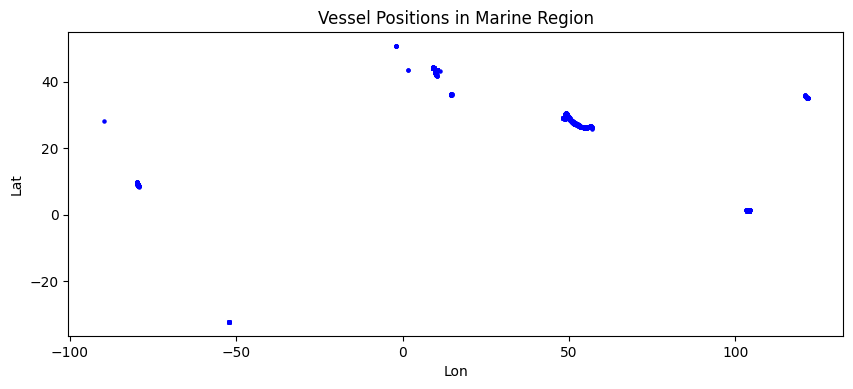

In [19]:
# Convert DataFrame to GeoDataFrame for plotting
geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Plot the positions
fig, ax = plt.subplots(figsize=(10, 10))
geo_df.plot(ax=ax, color='blue', markersize=5)
plt.title('Vessel Positions in Marine Region')
plt.xlabel('Lon')
plt.ylabel('Lat')
plt.show()


In [20]:
# Save the result to a CSV file
result_df.to_csv('vessel_proximity_events.csv', index=False)

# Display the final DataFrame
result_df.head()


,mmsi,timestamp,vessel_proximity
0,218719092,2023-03-14 18:30:00+00:00,[232345740]
1,218719092,2023-03-15 01:30:00+00:00,"[875832716, 232006548, 889799564, 232345740]"
2,218719092,2023-03-15 02:30:00+00:00,"[232006548, 889799564, 232345740, 875832716]"
3,218719092,2023-03-15 03:30:00+00:00,"[232006548, 232345740, 875832716, 889799564]"
4,218719092,2023-03-15 04:30:00+00:00,"[232006548, 889799564, 875832716, 232345740]"


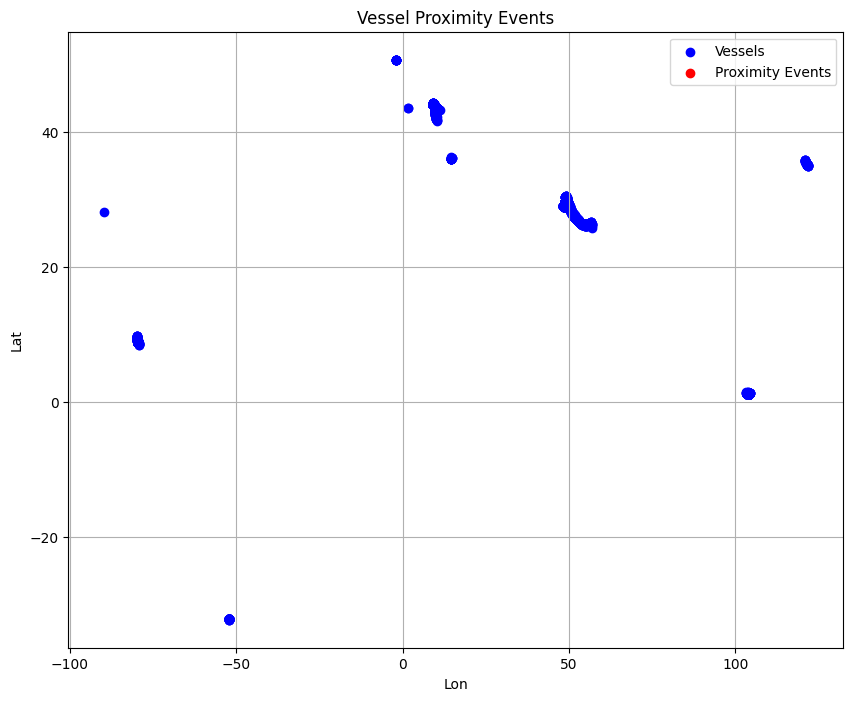

In [21]:
plt.figure(figsize=(10, 8))
plt.scatter(df['lon'], df['lat'], c='blue', label='Vessels')

# Example: Highlight proximity events for a specific vessel
vessel_of_interest = df[df['mmsi'] == 123456789]  # Replace with actual MMSI
plt.scatter(vessel_of_interest['lon'], vessel_of_interest['lat'], c='red', label='Proximity Events')

plt.xlabel('Lon')
plt.ylabel('Lat')
plt.title('Vessel Proximity Events')
plt.legend()
plt.grid(True)
plt.show()
